In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os # Sử dụng os cho đường dẫn như đã làm ở Phần 1
from IPython.display import display

#visual
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11

#link
project_root = os.path.dirname(os.getcwd())
processed_data_folder = os.path.join(project_root, 'data', 'bts_processed')
visualizations_folder = os.path.join(project_root, 'visualizations')

# Tạo thư mục visual
if not os.path.exists(visualizations_folder):
    os.makedirs(visualizations_folder)
    print('Đã tạo thư mục visualizations:', visualizations_folder)

input_filename = 'flight_delay_2024_preprocessed.csv'
processed_file_path = os.path.join(processed_data_folder, input_filename)

df_eda = None
if os.path.exists(processed_file_path):
    df_eda = pd.read_csv(processed_file_path)
    print('Đã load dữ liệu từ:', processed_file_path)
    print('Shape của df_eda:', df_eda.shape)
    display(df_eda.head()) # Hiển thị 5 dòng đầu tiên để xem qua dữ liệu
else:
    print('LỖI: Không tìm thấy file {}.'.format(processed_file_path))
    print('Vui lòng đảm bảo file đã được lưu từ Phần 1.')

Đã tạo thư mục visualizations: C:\Users\hoiti\PycharmProjects\flight_delay_bts_project\visualizations
Đã load dữ liệu từ: C:\Users\hoiti\PycharmProjects\flight_delay_bts_project\data\bts_processed\flight_delay_2024_preprocessed.csv
Shape của df_eda: (5677, 13)


,airport,arr_cancelled,arr_diverted,arr_flights,carrier,carrier_ct,delay_rate,late_aircraft_ct,month,nas_ct,security_ct,weather_ct,year
0,SGF,0.0,0.0,119.0,OH,5.50,0.134454,6.90,10,3.60,0.0,0.0,2024
1,SHV,0.0,0.0,92.0,OH,4.56,0.130435,1.52,10,5.92,0.0,0.0,2024
2,SRQ,7.0,0.0,31.0,OH,0.40,0.096774,2.57,10,0.03,0.0,0.0,2024
3,STL,0.0,0.0,115.0,OH,6.87,0.130435,7.79,10,0.33,0.0,0.0,2024
4,SYR,0.0,0.0,15.0,OH,1.42,0.266667,1.53,10,1.06,0.0,0.0,2024



--- 2.1. Phân Tích Biến Mục Tiêu: delay_rate ---

Thống kê mô tả của delay_rate:


count    5677.000000
mean        0.165472
std         0.099270
min         0.000000
25%         0.102564
50%         0.152104
75%         0.214286
max         1.000000
Name: delay_rate, dtype: float64

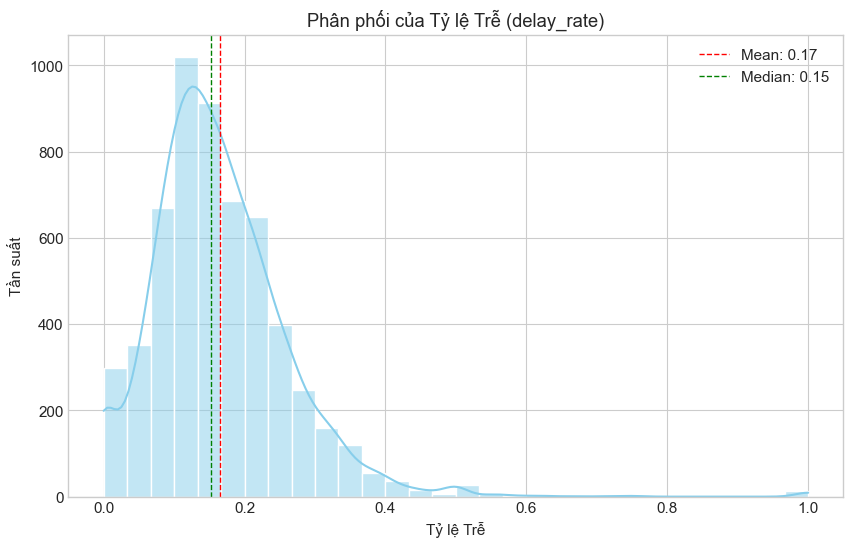

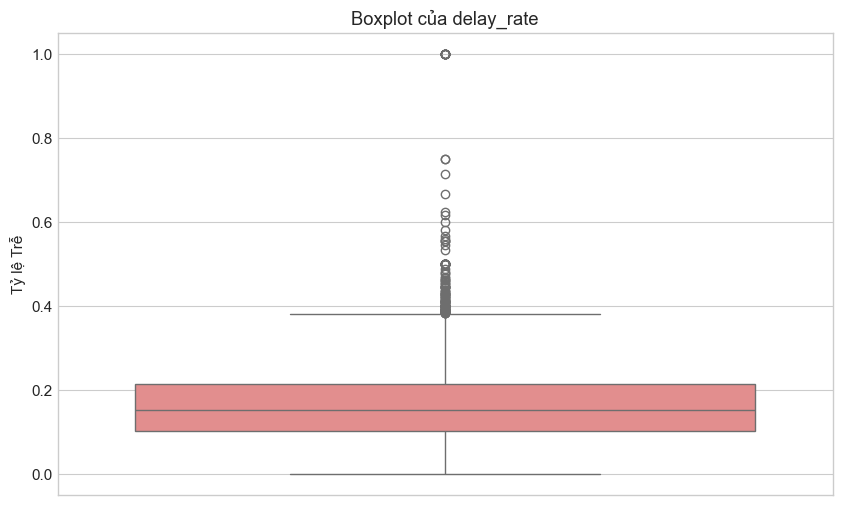

In [2]:
if df_eda is not None and not df_eda.empty: # Kiểm tra df_eda có dữ liệu không
    print("\n--- 2.1. Phân Tích Biến Mục Tiêu: delay_rate ---")

    print("\nThống kê mô tả của delay_rate:")
    display(df_eda['delay_rate'].describe()) # Hiển thị các thống kê cơ bản

    # Biểu đồ phân phối
    plt.figure() # Tạo một figure mới cho biểu đồ này
    sns.histplot(df_eda['delay_rate'], bins=30, kde=True, color='skyblue')
    plt.title('Phân phối của Tỷ lệ Trễ (delay_rate)')
    plt.xlabel('Tỷ lệ Trễ')
    plt.ylabel('Tần suất')
    mean_val = df_eda['delay_rate'].mean() # Tính giá trị trung bình
    median_val = df_eda['delay_rate'].median() # Tính giá trị trung vị
    # Vẽ đường thẳng đứng cho mean và median trên biểu đồ
    plt.axvline(mean_val, color='red', linestyle='--', linewidth=1, label='Mean: {:.2f}'.format(mean_val))
    plt.axvline(median_val, color='green', linestyle='--', linewidth=1, label='Median: {:.2f}'.format(median_val))
    plt.legend()
    plt.savefig(os.path.join(visualizations_folder, 'delay_rate_distribution.png'))
    plt.show()

    # Boxplot để xem outliers (giá trị ngoại lệ)
    plt.figure()
    sns.boxplot(y=df_eda['delay_rate'], color='lightcoral')
    plt.title('Boxplot của delay_rate')
    plt.ylabel('Tỷ lệ Trễ')
    plt.savefig(os.path.join(visualizations_folder, 'delay_rate_boxplot.png'))
    plt.show()
else:
    print("df_eda chưa được load hoặc rỗng. Bỏ qua phân tích biến mục tiêu.")


--- 2.3. Phân Tích delay_rate và Các Nguyên Nhân Trễ ---
Đã tạo các cột tỷ lệ nguyên nhân trễ: ['carrier_ct_rate', 'weather_ct_rate', 'nas_ct_rate', 'security_ct_rate', 'late_aircraft_ct_rate']


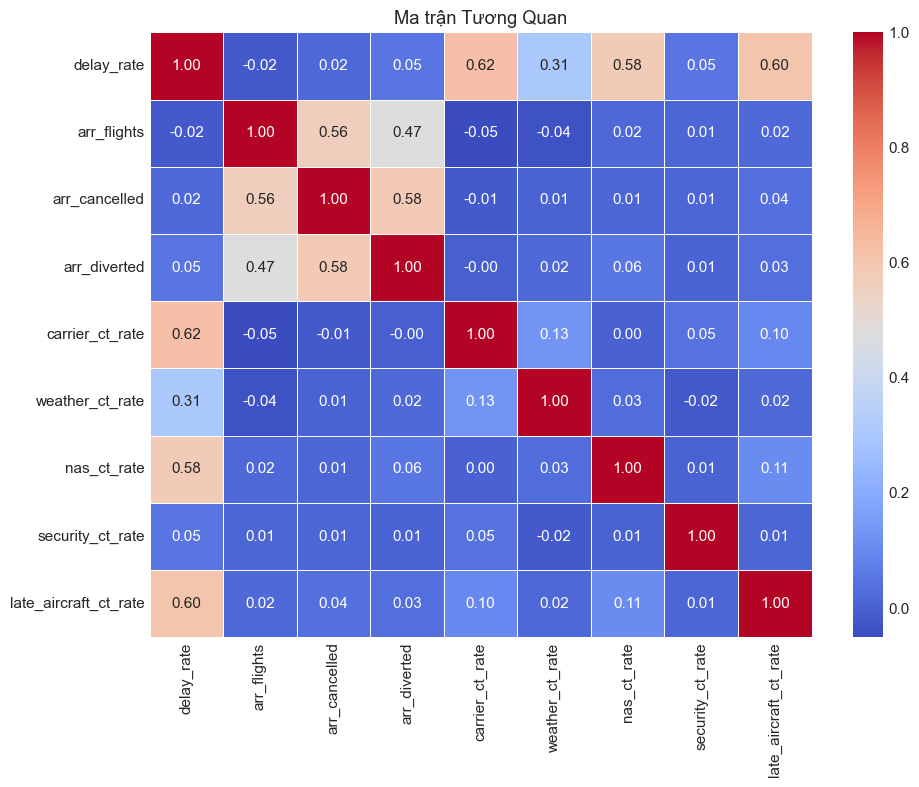

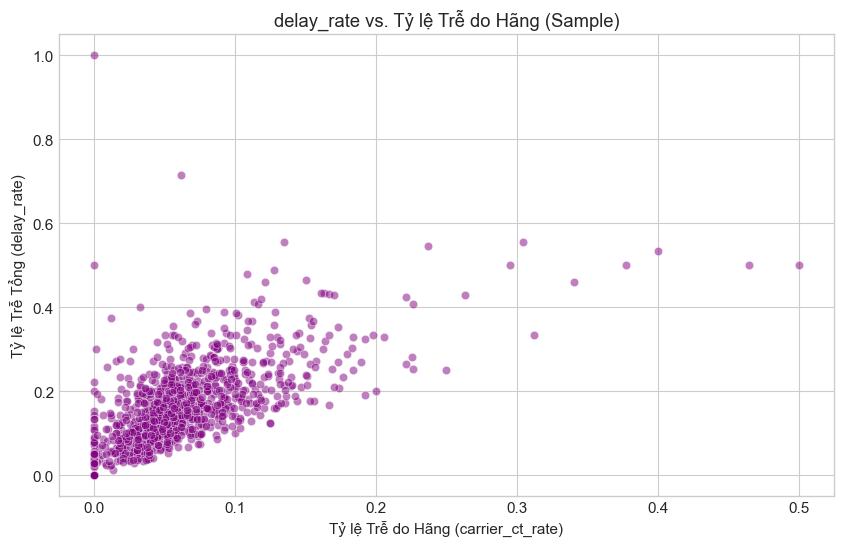

In [3]:
if df_eda is not None and not df_eda.empty:
    print("\n--- 2.3. Phân Tích delay_rate và Các Nguyên Nhân Trễ ---")

    delay_cause_count_cols = ['carrier_ct', 'weather_ct', 'nas_ct', 'security_ct', 'late_aircraft_ct']
    new_rate_cols = [] # List để lưu tên các cột tỷ lệ mới được tạo

    if 'arr_flights' in df_eda.columns: # Chỉ tạo cột tỷ lệ nếu có 'arr_flights'
        for cause_col in delay_cause_count_cols:
            if cause_col in df_eda.columns: # Kiểm tra từng cột nguyên nhân trễ
                new_col_name = cause_col + '_rate' # Tạo tên cột mới, ví dụ: 'carrier_ct_rate'
                # Tính tỷ lệ: số chuyến trễ do nguyên nhân X / tổng số chuyến bay
                # Giả định arr_flights > 0 (đã được lọc ở Phần 1)
                df_eda[new_col_name] = df_eda[cause_col] / df_eda['arr_flights']
                new_rate_cols.append(new_col_name) # Thêm tên cột mới vào list
        if new_rate_cols:
             print('Đã tạo các cột tỷ lệ nguyên nhân trễ:', new_rate_cols)
    else:
        print('CẢNH BÁO: Không có cột arr_flights, không thể tạo cột tỷ lệ.')

    # Các cột để tính ma trận tương quan
    correlation_cols_base = ['delay_rate', 'arr_flights', 'arr_cancelled', 'arr_diverted']
    # Lọc và gộp các cột: chỉ lấy các cột thực sự tồn tại trong df_eda
    existing_correlation_cols = [col for col in correlation_cols_base if col in df_eda.columns] + \
                                [col for col in new_rate_cols if col in df_eda.columns]

    if len(existing_correlation_cols) > 1 : # Cần ít nhất 2 cột để tính ma trận tương quan
        # Tính ma trận tương quan Pearson
        correlation_matrix = df_eda[existing_correlation_cols].corr()

        plt.figure(figsize=(10, 8)) # Kích thước cho heatmap
        # sns.heatmap vẽ ma trận tương quan dưới dạng bản đồ nhiệt
        # annot=True: hiển thị giá trị tương quan trên các ô
        # cmap='coolwarm': bảng màu (từ xanh dương cho âm đến đỏ cho dương)
        # fmt='.2f': định dạng số hiển thị (2 chữ số sau dấu phẩy)
        # linewidths=.5: vẽ đường kẻ giữa các ô
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
        plt.title('Ma trận Tương Quan')
        plt.tight_layout()
        plt.savefig(os.path.join(visualizations_folder, 'correlation_matrix_delay_causes.png'))
        plt.show()

    # Scatter plot ví dụ để xem xét mối quan hệ chi tiết hơn
    # Giữa 'carrier_ct_rate' và 'delay_rate'
    if 'carrier_ct_rate' in df_eda.columns and 'delay_rate' in df_eda.columns:
        plt.figure()
        sample_size = min(1000, len(df_eda)) # Lấy mẫu nhỏ nếu dữ liệu lớn
        if sample_size > 0:
            sample_df = df_eda.sample(n=sample_size, random_state=42) # random_state để kết quả lặp lại được
            # sns.scatterplot vẽ biểu đồ phân tán
            # alpha=0.5 làm cho các điểm hơi trong suốt, hữu ích khi có nhiều điểm chồng chéo
            sns.scatterplot(x='carrier_ct_rate', y='delay_rate', data=sample_df, alpha=0.5, color='purple')
            plt.title('delay_rate vs. Tỷ lệ Trễ do Hãng (Sample)')
            plt.xlabel('Tỷ lệ Trễ do Hãng (carrier_ct_rate)')
            plt.ylabel('Tỷ lệ Trễ Tổng (delay_rate)')
            plt.savefig(os.path.join(visualizations_folder, 'scatter_delay_vs_carrier_ct_rate.png'))
            plt.show()
else:
    print("df_eda chưa được load hoặc rỗng. Bỏ qua phân tích tương quan.")


--- 2.4. Phân Tích Đa Biến (Pairplot ví dụ) ---


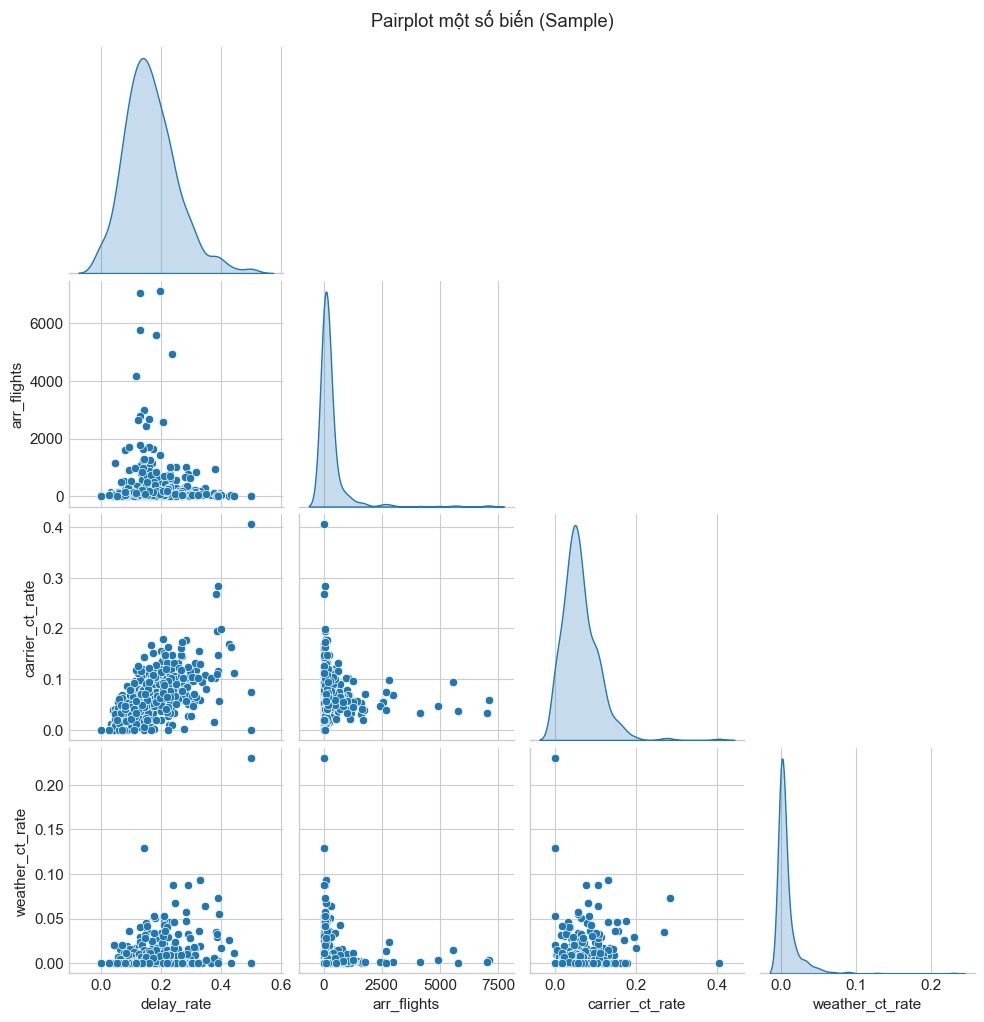

In [4]:
if df_eda is not None and not df_eda.empty:
    # Xác định các cột để vẽ pairplot
    cols_for_pairplot_check = ['delay_rate', 'arr_flights']
    # Kiểm tra xem biến new_rate_cols (từ cell trước) có tồn tại và có phần tử không
    if 'new_rate_cols' in locals() and new_rate_cols:
        cols_for_pairplot_check.extend(new_rate_cols[:2]) # Thêm 2 cột tỷ lệ đầu tiên vào danh sách

    # Lọc lại danh sách, chỉ giữ các cột thực sự tồn tại trong df_eda
    pairplot_cols = [col for col in cols_for_pairplot_check if col in df_eda.columns]

    if len(pairplot_cols) > 1: # Pairplot cần ít nhất 2 cột để vẽ
        print("\n--- 2.4. Phân Tích Đa Biến (Pairplot ví dụ) ---")
        sample_size_pairplot = min(500, len(df_eda)) # Lấy mẫu nhỏ hơn cho pairplot
        if sample_size_pairplot > 0 :
            # sns.pairplot vẽ một ma trận các biểu đồ.
            # Đường chéo chính: phân phối của từng biến (kde = Kernel Density Estimate).
            # Các ô khác: scatter plot giữa các cặp biến.
            # corner=True: chỉ vẽ nửa dưới của ma trận (vì nửa trên đối xứng).
            sns.pairplot(df_eda[pairplot_cols].sample(n=sample_size_pairplot, random_state=1), diag_kind='kde', corner=True)
            plt.suptitle('Pairplot một số biến (Sample)', y=1.02) # Tiêu đề chung cho toàn bộ pairplot
            plt.savefig(os.path.join(visualizations_folder, 'pairplot_selected_features.png'))
            plt.show()
else:
    print("df_eda chưa được load hoặc rỗng. Bỏ qua pairplot.")